In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from LDA import *
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.enable_eager_execution()

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, SpatialDropout1D
from keras.layers import LSTM, SimpleRNN, GRU
from keras.regularizers import l2
from keras.constraints import maxnorm
from keras.datasets import imdb

import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5



In [2]:
from numpy.random import seed
seed(1337)
tf.random.set_seed(42)

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 12 # the number of joints
        self.joint_n = 22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 231
        self.filters = 16
        self.data_dir = 'C:\\Users\\Joseph\\Documents\\Vedecom\\SHREC_JHMDB\\DD-Net-master\\data\\SHREC\\'
C = Config()

Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

#Load Data

In [4]:
X_0 = []
X_1 = []
X_2 =[]
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Train['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)
    M_cos = get_CG_cosine(p,C)

    X_0.append(M)
    X_1.append(M_cos)
    X_2.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1)
X_2 = np.stack(X_2)
Y = np.stack(Y)

  2%|▏         | 40/1960 [00:00<00:10, 191.52it/s]C:\Users\Joseph\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|██████████| 1960/1960 [00:10<00:00, 190.01it/s]


In [5]:
X_test_0 = []
X_test_1 = []
X_test_2 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)
    M_cos = get_CG_cosine(p,C)

    X_test_0.append(M)
    X_test_1.append(M_cos)
    X_test_2.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1) 
X_test_2 = np.stack(X_test_2)
Y_test = np.stack(Y_test)

100%|██████████| 840/840 [00:04<00:00, 192.69it/s]


#Data Norm

In [6]:
x_train = X_2
x_test = X_test_2
y_train =[np.where(r==1)[0][0] for r in Y]
y_test =[np.where(r==1)[0][0] for r in Y_test]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [7]:
itd = 13

input_bottleneck = Input(shape=(itd,), name="inp_bt")
input_img = Input(shape=(2112,), name="inp_img")
input_S = Input(shape=(itd,), name="inp_S")


encoded = Dense(512, activation='relu')(input_img)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.1)(encoded)

encoded = Dense(256, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.1)(encoded)

encoded = Dense(128, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.1)(encoded)

encoded = Dense(64, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.1)(encoded)

encoded = Dense(32, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.1)(encoded)

bottlenek = Dense(itd, activation='relu', name="bottleneck")(encoded)

decoded = Dense(32, activation='relu')(bottlenek)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.1)(decoded)

decoded = Dense(64, activation='relu')(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.1)(decoded)

decoded = Dense(128, activation='relu')(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.1)(decoded)

decoded = Dense(256, activation='relu')(decoded)
decoded = Dropout(0.1)(decoded)

decoded = Dense(512, activation='relu')(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.1)(decoded)

output = Dense(2112, activation='sigmoid', name="logits")(decoded)


final_dense = concatenate(
    [input_bottleneck, 
     output,
     input_S
    ], name="concatenate")

model2 = Model([input_bottleneck, input_img, input_S], [final_dense, output])
#model.load_weights("dae2_lle.h5")

bottleneck_model2 = Model(inputs=model2.get_layer("inp_img").input, outputs=model2.get_layer("bottleneck").output)

#model = Model(input_img, output)

In [8]:
from keras.callbacks import ReduceLROnPlateau
l = 0

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=1e-8)

adam = Adam(lr=1e-3, epsilon = 1e-8, beta_1 = .9, beta_2 = .999)

def custom_loss(y_true, y_pred):
    bottle=y_pred[:,:itd]
    pred = y_pred[:,itd:2112+itd]
    Sb = y_pred[:,2112+itd:]
    
#     return tf.norm(y_true - pred) + l*tf.norm(bottle - Sb)
#     return tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(y_true, pred))))
#     return K.sqrt(K.sum(K.square(y_true - pred))) 
#     return objectives.binary_crossentropy(y_true, pred) + l*objectives.binary_crossentropy(bottle, Sb)
    return K.sqrt(K.sum(K.square(y_true - pred), axis=-1)) + l*K.sqrt(K.sum(K.square(bottle - Sb), axis=-1))

model2.compile(optimizer=adam, loss={"concatenate":custom_loss, "logits": None})
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp_img (InputLayer)            (None, 2112)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          1081856     inp_img[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512)          2048        dense_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 512)          0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [9]:
sub_train = [x_train[x:x+1960] for x in range(0, len(x_train), 1960)]
label_sub = [y_train[x:x+1960] for x in range(0, len(y_train), 1960)]

In [10]:
for epoch in range(0,100):
    for x in sub_train:
        i = 0
        bottleneck = bottleneck_model2.predict(x)
        lle = LinearDiscriminantAnalysis()
        lle.fit(bottleneck, label_sub[i])
        S = lle.get_projection(bottleneck)
        #print(S.shape)
        z = np.zeros((1960,1))
        g = S
        #g = np.append(S, z, axis=1)
        #print(g.shape)
        while (str(g.shape) != "(1960, 13)"):
            g = np.append(g, z, axis=1)
        sdotB = g
        lss = model2.train_on_batch(
            [
                 bottleneck, 
                 x,
                 sdotB
            ], 
                x
        )
        i = i +1
    print("epoch : ", epoch, " : ",lss)

epoch :  0  :  [23.831583, 23.831583]
epoch :  1  :  [23.578773, 23.578773]
epoch :  2  :  [23.170336, 23.170336]
epoch :  3  :  [22.69068, 22.69068]
epoch :  4  :  [22.008343, 22.008343]
epoch :  5  :  [21.182804, 21.182804]
epoch :  6  :  [20.136965, 20.136965]
epoch :  7  :  [19.032637, 19.032637]
epoch :  8  :  [17.749115, 17.749115]
epoch :  9  :  [16.467443, 16.467443]
epoch :  10  :  [15.057823, 15.057823]
epoch :  11  :  [13.919864, 13.919864]
epoch :  12  :  [12.776784, 12.776784]
epoch :  13  :  [11.882766, 11.882766]
epoch :  14  :  [10.850805, 10.850805]
epoch :  15  :  [10.275325, 10.275325]
epoch :  16  :  [9.500432, 9.500432]
epoch :  17  :  [8.948926, 8.948926]
epoch :  18  :  [8.458253, 8.458253]
epoch :  19  :  [7.9285645, 7.9285645]
epoch :  20  :  [7.590468, 7.590468]
epoch :  21  :  [7.2818193, 7.2818193]
epoch :  22  :  [6.773391, 6.773391]
epoch :  23  :  [6.450526, 6.450526]
epoch :  24  :  [6.269465, 6.269465]
epoch :  25  :  [6.058618, 6.058618]
epoch :  26  :

In [11]:
new = bottleneck_model2.predict(x_train)
new.shape
len(Y)

1960

In [12]:
import time
from sklearn.manifold import TSNE

N = 1960
df_subset = new
data_subset =new

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(new)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1960 samples in 0.001s...
[t-SNE] Computed neighbors for 1960 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1960
[t-SNE] Computed conditional probabilities for sample 1960 / 1960
[t-SNE] Mean sigma: 0.000790
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.297920
[t-SNE] KL divergence after 300 iterations: 1.476140
t-SNE done! Time elapsed: 2.513831377029419 seconds


In [13]:
# Utility function to visualize the outputs of PCA and t-SNE

def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=32)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<Figure size 576x576 with 1 Axes>,
 [Text(-12.975172, -0.9365758, '0'),
  Text(3.8311713, -4.456074, '1'),
  Text(7.4742684, -15.154922, '2'),
  Text(-8.7919855, -10.3621, '3'),
  Text(-5.9321885, -6.4976244, '4'),
  Text(-2.2698636, -4.244026, '5'),
  Text(-10.863501, 12.9336605, '6'),
  Text(6.4449635, 4.737623, '7'),
  Text(4.715518, -0.81241125, '8'),
  Text(-0.78525424, 6.972655, '9'),
  Text(11.649592, 12.205319, '10'),
  Text(14.069331, 10.832154, '11'),
  Text(0.83066493, 14.985153, '12'),
  Text(-5.134782, -12.967052, '13')])

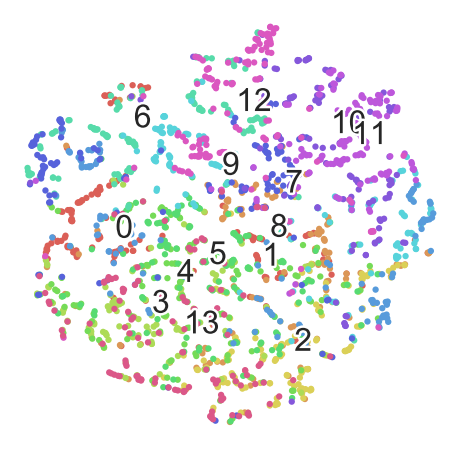

In [14]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123

tsne_results =  np.array(tsne_results, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
fashion_scatter(tsne_results, y_train)

In [26]:
itd = 13

input_bottleneck = Input(shape=(itd,), name="inp_bt")
input_img = Input(shape=(2112,), name="inp_img")
input_S = Input(shape=(itd,), name="inp_S")


encoded = Dense(512, activation='relu')(input_img)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.1)(encoded)

encoded = Dense(256, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.1)(encoded)

encoded = Dense(128, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.1)(encoded)

encoded = Dense(64, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.1)(encoded)

encoded = Dense(32, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.1)(encoded)

bottlenek = Dense(itd, activation='relu', name="bottleneck")(encoded)

decoded = Dense(32, activation='relu')(bottlenek)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.1)(decoded)

decoded = Dense(64, activation='relu')(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.1)(decoded)

decoded = Dense(128, activation='relu')(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.1)(decoded)

decoded = Dense(256, activation='relu')(decoded)
decoded = Dropout(0.1)(decoded)

decoded = Dense(512, activation='relu')(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.1)(decoded)

output = Dense(2112, activation='sigmoid', name="logits")(decoded)


final_dense = concatenate(
    [input_bottleneck, 
     output,
     input_S
    ], name="concatenate")

model3 = Model([input_bottleneck, input_img, input_S], [final_dense, output])
#model.load_weights("dae2_lle.h5")

bottleneck_model3 = Model(inputs=model3.get_layer("inp_img").input, outputs=model3.get_layer("bottleneck").output)

#model = Model(input_img, output)

In [27]:
from keras.callbacks import ReduceLROnPlateau
l = 5

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=1e-8)

adam = Adam(lr=1e-3, epsilon = 1e-8, beta_1 = .9, beta_2 = .999)

def custom_loss(y_true, y_pred):
    bottle=y_pred[:,:itd]
    pred = y_pred[:,itd:2112+itd]
    Sb = y_pred[:,2112+itd:]
    
#     return tf.norm(y_true - pred) + l*tf.norm(bottle - Sb)
#     return tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(y_true, pred))))
#     return K.sqrt(K.sum(K.square(y_true - pred))) 
#     return objectives.binary_crossentropy(y_true, pred) + l*objectives.binary_crossentropy(bottle, Sb)
    return K.sqrt(K.sum(K.square(y_true - pred), axis=-1)) + l*K.sqrt(K.sum(K.square(bottle - Sb), axis=-1))

model3.compile(optimizer=adam, loss={"concatenate":custom_loss, "logits": None})
model3.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp_img (InputLayer)            (None, 2112)         0                                            
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 512)          1081856     inp_img[0][0]                    
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 512)          2048        dense_31[0][0]                   
__________________________________________________________________________________________________
dropout_31 (Dropout)            (None, 512)          0           batch_normalization_28[0][0]     
____________________________________________________________________________________________

In [28]:
sub_train = [x_train[x:x+1960] for x in range(0, len(x_train), 1960)]
label_sub = [y_train[x:x+1960] for x in range(0, len(y_train), 1960)]

In [29]:
for epoch in range(0,120):
    for x in sub_train:
        i = 0
        bottleneck = bottleneck_model3.predict(x)
        lle = LinearDiscriminantAnalysis()
        lle.fit(bottleneck, label_sub[i])
        S = lle.get_projection(bottleneck)
        #print(S.shape)
        z = np.zeros((1960,1))
        g = S
        #g = np.append(S, z, axis=1)
        #print(g.shape)
        while (str(g.shape) != "(1960, 13)"):
            g = np.append(g, z, axis=1)
        sdotB = g
        lss = model3.train_on_batch(
            [
                 bottleneck, 
                 x,
                 sdotB
            ], 
                x
        )
        i = i +1
    print("epoch : ", epoch, " : ",lss)

epoch :  0  :  [42.128677, 42.128677]
epoch :  1  :  [34.23477, 34.23477]
epoch :  2  :  [32.47964, 32.47964]
epoch :  3  :  [33.528164, 33.528164]
epoch :  4  :  [31.376259, 31.376259]
epoch :  5  :  [30.44644, 30.44644]
epoch :  6  :  [29.86551, 29.86551]
epoch :  7  :  [28.113184, 28.113184]
epoch :  8  :  [27.273836, 27.273836]
epoch :  9  :  [25.967157, 25.967157]
epoch :  10  :  [24.914135, 24.914135]
epoch :  11  :  [24.16459, 24.16459]
epoch :  12  :  [22.817087, 22.817087]
epoch :  13  :  [20.82486, 20.82486]
epoch :  14  :  [18.845638, 18.845638]
epoch :  15  :  [18.572525, 18.572525]
epoch :  16  :  [18.73818, 18.73818]
epoch :  17  :  [17.721928, 17.721928]
epoch :  18  :  [17.764717, 17.764717]
epoch :  19  :  [17.057123, 17.057123]
epoch :  20  :  [16.393316, 16.393316]
epoch :  21  :  [15.849282, 15.849282]
epoch :  22  :  [15.715113, 15.715113]
epoch :  23  :  [15.38076, 15.38076]
epoch :  24  :  [15.191413, 15.191413]
epoch :  25  :  [16.889338, 16.889338]
epoch :  26 

In [24]:
new = bottleneck_model3.predict(x_train)
new.shape
len(Y)

1960

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1960 samples in 0.001s...
[t-SNE] Computed neighbors for 1960 samples in 0.038s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1960
[t-SNE] Computed conditional probabilities for sample 1960 / 1960
[t-SNE] Mean sigma: 0.001646
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.703682
[t-SNE] KL divergence after 300 iterations: 1.187280
t-SNE done! Time elapsed: 3.019899845123291 seconds


(<Figure size 576x576 with 1 Axes>,
 [Text(-6.030422, -1.8886671, '0'),
  Text(-2.0467942, 3.0635612, '1'),
  Text(7.5915675, 6.733606, '2'),
  Text(12.414251, 3.920938, '3'),
  Text(4.6413894, 2.9194033, '4'),
  Text(1.547052, 2.5768404, '5'),
  Text(1.9597954, -17.05769, '6'),
  Text(-10.963404, 5.438079, '7'),
  Text(10.866785, -4.1622777, '8'),
  Text(-2.7644885, -0.8237989, '9'),
  Text(-14.704513, 1.1901475, '10'),
  Text(-16.969833, 3.0760384, '11'),
  Text(-3.5447192, -12.473588, '12'),
  Text(13.572111, -0.25598463, '13')])

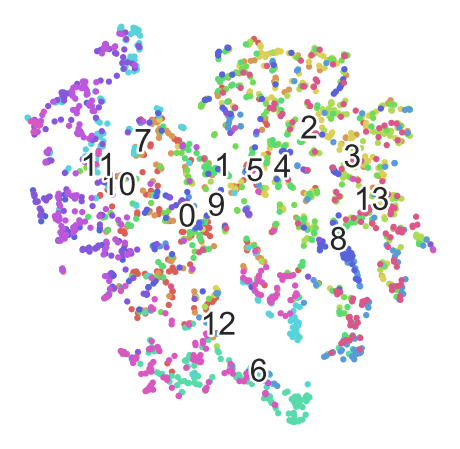

In [34]:
import time
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123

N = 1960
df_subset = new
data_subset =new

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=300)
tsne_results = tsne.fit_transform(new)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

tsne_results =  np.array(tsne_results, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
fashion_scatter(tsne_results, y_train)